### Importa Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pickle

### Funções

In [2]:
# Função para calcular o MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

### Parâmetros

In [3]:
data_inicial = '20180101'
data_final = '20231201'

# define target
target = 'PD'

### Importa Bases

In [4]:
# Carregar e preparar os dados
df = pd.read_parquet('base.parquet')

### Tratamento Base

In [5]:
# corte temporal
df = df[df['DATA_REFERENCIA'] >= data_inicial]
df = df[df['DATA_REFERENCIA'] <= data_final]


# definindo índice
df.set_index('DATA_REFERENCIA', inplace=True)


# Verificar as primeiras linhas
df.head()

,PD,IPCA_LAG_1,IPCA_LAG_3,IPCA_LAG_6,IPCA_LAG_12,DESEMPREGO_LAG_1,DESEMPREGO_LAG_3,DESEMPREGO_LAG_6,DESEMPREGO_LAG_12,PIB_LAG_1,...,PIB_LAG_6,PIB_LAG_12,SELIC_LAG_1,SELIC_LAG_3,SELIC_LAG_6,SELIC_LAG_12,CAMBIO_LAG_1,CAMBIO_LAG_3,CAMBIO_LAG_6,CAMBIO_LAG_12
DATA_REFERENCIA,,,,,,,,,,,,,,,,,,,,,
2018-01-01,3.861777,5.410274,5.159236,2.918972,4.657135,11.9,12.3,12.9,12.7,588892.8,...,557458.2,526564.7,6.675963,7.956187,10.033869,13.893348,3.291915,3.191229,3.206138,3.196609
2018-02-01,3.798198,3.536617,3.412864,2.303129,4.032747,12.3,12.1,12.7,13.3,555644.6,...,555578.7,514120.5,7.186373,7.058561,10.033869,10.954329,3.210609,3.259380,3.150917,3.104194
2018-03-01,3.815173,3.908738,5.410274,1.935750,3.040525,12.7,11.9,12.5,13.9,528905.5,...,528871.2,544312.9,5.788102,6.675963,7.956187,13.353730,3.241500,3.291915,3.134790,3.127930
2018-04-01,3.823845,1.084909,3.536617,5.159236,1.692904,13.2,12.3,12.3,13.7,560120.7,...,549304.7,525238.1,6.548709,7.186373,7.956187,9.902948,3.279214,3.210609,3.191229,3.136172
2018-05-01,3.876315,2.671660,3.908738,3.412864,3.784558,13.0,12.7,12.1,13.4,559359.8,...,566209.3,548887.7,6.421594,5.788102,7.058561,11.748906,3.407495,3.241500,3.259380,3.209509


### Separação Treino/Teste

In [6]:
# Separar em treino e teste
train_size = int(len(df) * 0.8)  
df_train = df.iloc[:train_size]
len(df_train)

57

In [7]:
test_size = len(df) - train_size
df_test = df.iloc[train_size:]
len(df_test)

15

In [8]:
# Separar variáveis explicativas e alvo
X_train = df_train.drop(columns=[target])
y_train = df_train[target]
X_test = df_test.drop(columns=[target])
y_test = df_test[target]

### Normalização das Variáveis

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Multicolinearidade

A multicolinearidade geralmente não é um problema significativo em modelos como o XGBoost.

**Algoritmos Baseados em Árvores:**

O XGBoost é um algoritmo baseado em árvores de decisão. As árvores selecionam divisores ("splits") baseados em critérios como ganho de informação ou redução de erro, avaliando variáveis individualmente a cada passo.

Como resultado, a alta correlação entre variáveis não interfere diretamente no processo de seleção de divisores, pois cada variável é avaliada com base em sua contribuição incremental à redução do erro.

**Regularização Incorporada:**

O XGBoost utiliza regularização L1 (Lasso) e L2 (Ridge), que ajudam a penalizar coeficientes e reduzir a influência de variáveis redundantes.

Isso é particularmente útil em cenários com multicolinearidade, pois variáveis altamente correlacionadas podem ser automaticamente ignoradas ou ajustadas pelo algoritmo.

**Redundância e Importância de Variáveis:**

Em caso de multicolinearidade, o XGBoost pode priorizar uma variável em detrimento de outra altamente correlacionada, mas isso não impacta negativamente a performance do modelo. A redundância entre variáveis geralmente não prejudica a capacidade do modelo de aprender.

**Interpretação vs. Performance:**

Embora a multicolinearidade não afete a performance preditiva do XGBoost, ela pode dificultar a interpretação dos resultados (como a importância das variáveis). Em análises onde a interpretação é fundamental, como análises estatísticas tradicionais, seria importante abordar a multicolinearidade.

### Otimização de Hiperparâmetros

**n_estimators:**

Representa o número de árvores na floresta.
Quanto mais árvores, maior a capacidade do modelo de aprender padrões complexos, mas também aumenta o tempo de treinamento e risco de overfitting.

**learning_rate:**

Controla o tamanho do passo que o modelo dá ao ajustar os pesos em cada iteração.
Taxas menores resultam em aprendizado mais lento, mas podem produzir um modelo melhor (desde que com mais árvores).

**max_depth:**

Define a profundidade máxima de cada árvore.
Árvores mais profundas capturam padrões mais complexos, mas correm maior risco de overfitting.

**subsample:**

Proporção de amostras usadas para treinar cada árvore.
Valores menores que 1.0 introduzem regularização, ajudando a prevenir overfitting.

**colsample_bytree:**

Proporção de variáveis (features) usadas para treinar cada árvore.
Similar a subsample, reduz o risco de overfitting ao considerar apenas um subconjunto de variáveis por vez.

In [10]:
param_grid = {
    'n_estimators': list(range(0,501)), # Número de árvores
    'learning_rate': np.linspace(0.01, 0.1, 100), # Taxa de aprendizado
    'max_depth': list(range(3, 20)), # Profundidade máxima
    'subsample': np.linspace(0.3, 1.0, 100), # Proporção de amostras
    'colsample_bytree': np.linspace(0.3, 1.0, 1) # Proporção de variáveis
}

xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_grid,
    scoring='neg_root_mean_squared_error',
    n_iter=20,
    cv=3,
    verbose=1,
    random_state=42
)

xgb_random.fit(X_train_scaled, y_train)
print(f"Best Parameters: {xgb_random.best_params_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.7737373737373737, 'n_estimators': 17, 'max_depth': 5, 'learning_rate': 0.08, 'colsample_bytree': 0.3}


### Treinamento do Modelo

In [11]:
# Aplicando os melhores parâmetros ao modelo
xgb_model = XGBRegressor(
    random_state=42,  # Mantenha o random_state para reprodutibilidade
    **xgb_random.best_params_    # Descompacta e aplica os melhores parâmetros
)

In [12]:
# Treinamento
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=17, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Importância das Variáveis

In [13]:
importances = xgb_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
feature_importance.sort_values('Importance', ascending=False)

,Feature,Importance
9,PIB_LAG_3,0.483599
18,CAMBIO_LAG_6,0.080434
15,SELIC_LAG_12,0.070745
8,PIB_LAG_1,0.053152
12,SELIC_LAG_1,0.040424
19,CAMBIO_LAG_12,0.037428
13,SELIC_LAG_3,0.031082
16,CAMBIO_LAG_1,0.029239
7,DESEMPREGO_LAG_12,0.026037
17,CAMBIO_LAG_3,0.024273


### Predições do Modelo

In [14]:
# Previsões no conjunto de teste
y_test_pred = xgb_model.predict(X_test_scaled)

In [15]:
# Previsões no conjunto de treino
y_train_pred = xgb_model.predict(X_train_scaled)

### R2 Modelo

In [21]:
# Calcular o R² no treino
r2_train = r2_score(y_train, y_train_pred)

# Número de observações (n) e número de variáveis explicativas (k)
n = len(y_train)
k = X_train.shape[1]  # Número de variáveis explicativas

# Calcular o R² ajustado no treino
r2_train_adjusted = 1 - ((1 - r2_train) * (n - 1) / (n - k - 1))

print(f'Treino R²: {r2_train:.4f}')
print(f'Treino R² ajustado: {r2_train_adjusted:.4f}')

Treino R²: 0.8430
Treino R² ajustado: 0.7558


### Análise dos Resíduos



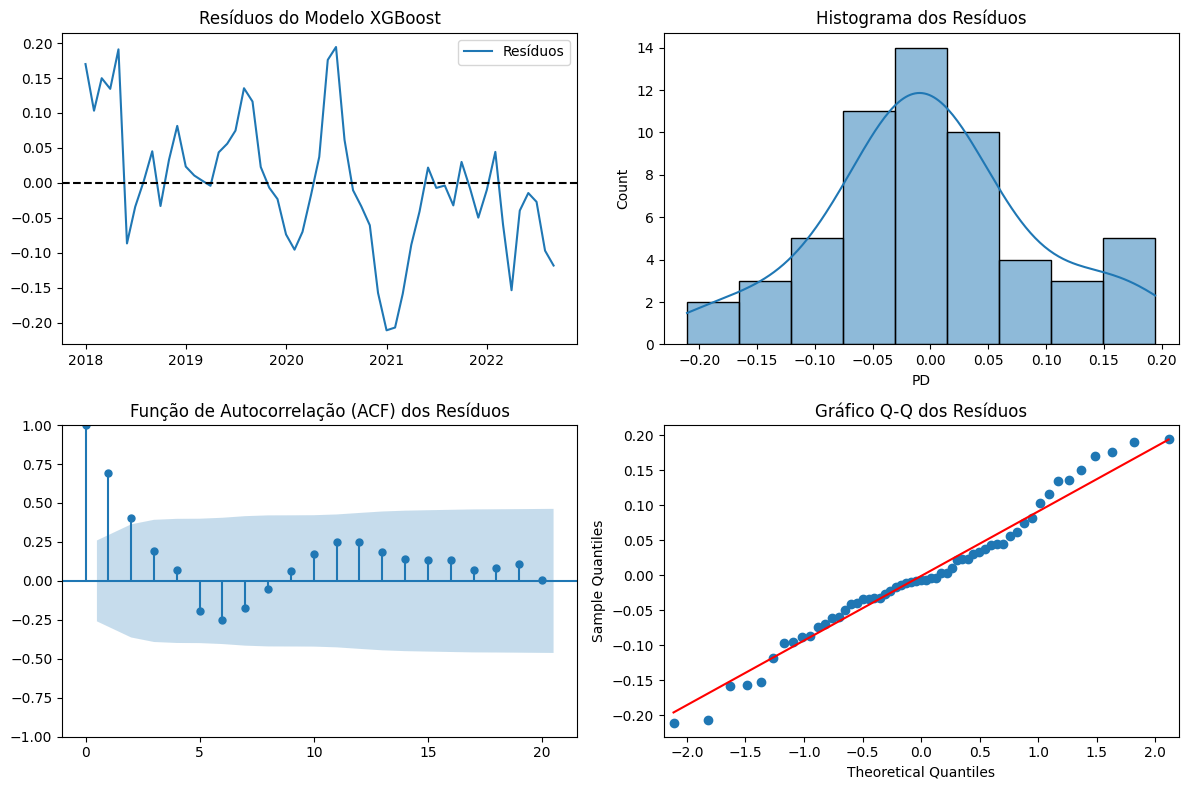


Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: 0.0456
   - p-valor: 0.9774
   Os resíduos seguem uma distribuição normal.

2. Teste de Ljung-Box (lag 10):
   - Estatística: 52.4738
   - p-valor: 0.0000
   Há autocorrelação significativa nos resíduos.




In [23]:
# Pegando os resíduos do modelo
residuos = y_train - y_train_pred

# Ajustando o erro no teste Jarque-Bera 
jb_stat, jb_pvalue = jarque_bera(residuos)

# Teste Ljung-Box
ljung_box_test = acorr_ljungbox(residuos, lags=[10], return_df=True)

# Criando os gráficos
plt.figure(figsize=(12, 8))

# Gráfico de resíduos
plt.subplot(2, 2, 1)
plt.plot(residuos, label='Resíduos')
plt.axhline(0, color='black', linestyle='--')
plt.title('Resíduos do Modelo XGBoost')
plt.legend()

# Histograma dos resíduos
plt.subplot(2, 2, 2)
sns.histplot(residuos, kde=True)
plt.title('Histograma dos Resíduos')

# ACF dos resíduos
plt.subplot(2, 2, 3)
sm.graphics.tsa.plot_acf(residuos, ax=plt.gca(), lags=20)
plt.title('Função de Autocorrelação (ACF) dos Resíduos')

# Q-Q plot
plt.subplot(2, 2, 4)
sm.qqplot(residuos, line='s', ax=plt.gca())
plt.title('Gráfico Q-Q dos Resíduos')

plt.tight_layout()
plt.show()

# Interpretando os resultados
interpretation = f"""
Interpretação dos Resultados:

1. Teste de Jarque-Bera:
   - Estatística: {jb_stat:.4f}
   - p-valor: {jb_pvalue:.4f}
   {'Os resíduos seguem uma distribuição normal.' if jb_pvalue > 0.05 else 'Os resíduos não seguem uma distribuição normal.'}

2. Teste de Ljung-Box (lag 10):
   - Estatística: {ljung_box_test['lb_stat'].values[0]:.4f}
   - p-valor: {ljung_box_test['lb_pvalue'].values[0]:.4f}
   {'Não há autocorrelação significativa nos resíduos.' if ljung_box_test['lb_pvalue'].values[0] > 0.05 else 'Há autocorrelação significativa nos resíduos.'}

"""

print(interpretation)

### Vizualização Gráfica

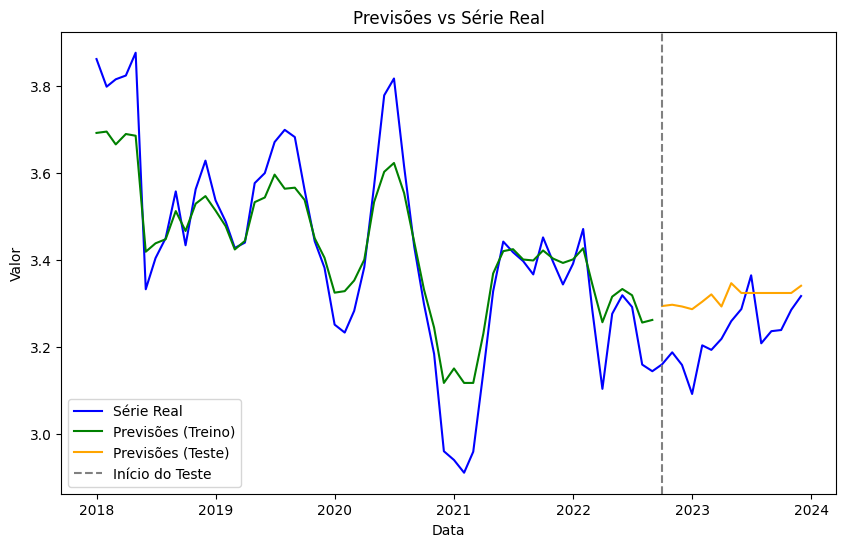

In [18]:
# Visualizar os resultados
plt.figure(figsize=(10, 6))
# Série real
plt.plot(df.index, df[target], label='Série Real', color='blue')
# Previsões no treino
plt.plot(df_train.index, y_train_pred, label='Previsões (Treino)', color='green')
# Previsões no teste
plt.plot(df_test.index, y_test_pred, label='Previsões (Teste)', color='orange')
# Linha vertical indicando o início do conjunto de teste
plt.axvline(x=df_test.index[0], color='gray', linestyle='--', label='Início do Teste')
# Configurações adicionais
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.title('Previsões vs Série Real')
plt.show()

### Métricas do Modelo

In [19]:
# Dados para treino
rmse_train = np.sqrt(mean_squared_error(df_train[target], y_train_pred))
mae_train = mean_absolute_error(df_train[target], y_train_pred)
mape_train = mean_absolute_percentage_error(df_train[target], y_train_pred)

# Dados para teste
rmse_test = np.sqrt(mean_squared_error(df_test[target], y_test_pred))
mae_test = mean_absolute_error(df_test[target], y_test_pred)
mape_test = mean_absolute_percentage_error(df_test[target], y_test_pred)

# Exibindo os resultados
print("Métricas para o Conjunto de Treino:")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"MAPE: {mape_train:.2f}%")

print("\nMétricas para o Conjunto de Teste:")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"MAPE: {mape_test:.2f}%")

Métricas para o Conjunto de Treino:
RMSE: 0.0922
MAE: 0.0700
MAPE: 2.06%

Métricas para o Conjunto de Teste:
RMSE: 0.1030
MAE: 0.0928
MAPE: 2.90%


### Salvando Modelo

In [20]:
# Nome do arquivo onde o modelo será salvo
model_filename = 'modelo_xgb_completo.pkl'

# Salvando o modelo em um arquivo pickle
with open(model_filename, 'wb') as file:
    pickle.dump(xgb_model, file)

print(f"Modelo salvo em: {model_filename}")

Modelo salvo em: modelo_xgb_completo.pkl
